In [ ]:
# Лабораторная работа 2
# 3374
# Лобачев Иван Максимович
# Знакомство с методом кластеризации K-mean с помощью пакета sklearn

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Загрузка данных
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')
print(f"Размер исходного датасета: {df.shape}")
display(df.head())

Данные загружены!
Размер исходного датасета: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [ ]:
# Добавление новых атрибутов
df['acidity_ratio'] = df['fixed acidity'] / df['volatile acidity']
df['sulfur_ratio'] = df['free sulfur dioxide'] / df['total sulfur dioxide']
print("Добавлены новые атрибуты:")
print("- acidity_ratio (отношение общей кислотности к летучей)")
print("- sulfur_ratio (отношение свободного SO2 к общему)")
print(f"Новый размер датасета: {df.shape}")

Добавлены новые атрибуты:
- acidity_ratio (отношение общей кислотности к летучей)
- sulfur_ratio (отношение свободного SO2 к общему)
Новый размер датасета: (1599, 14)


In [ ]:
# Предобработка данных

# Обработка бесконечных значений
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.median())

# Удаление дубликатов
initial_size = len(df)
df = df.drop_duplicates()
print(f"Удалено дубликатов: {initial_size - len(df)}")

# Функция для удаления выбросов
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Удаление выбросов из ключевых столбцов
outlier_columns = ['residual sugar', 'free sulfur dioxide', 'total sulfur dioxide']
for col in outlier_columns:
    df = remove_outliers(df, col)

print(f"Размер датасета после обработки выбросов: {df.shape}")

Удалено дубликатов: 0
Размер датасета после обработки выбросов: (1132, 15)


Визуализация потенциальных кластеров


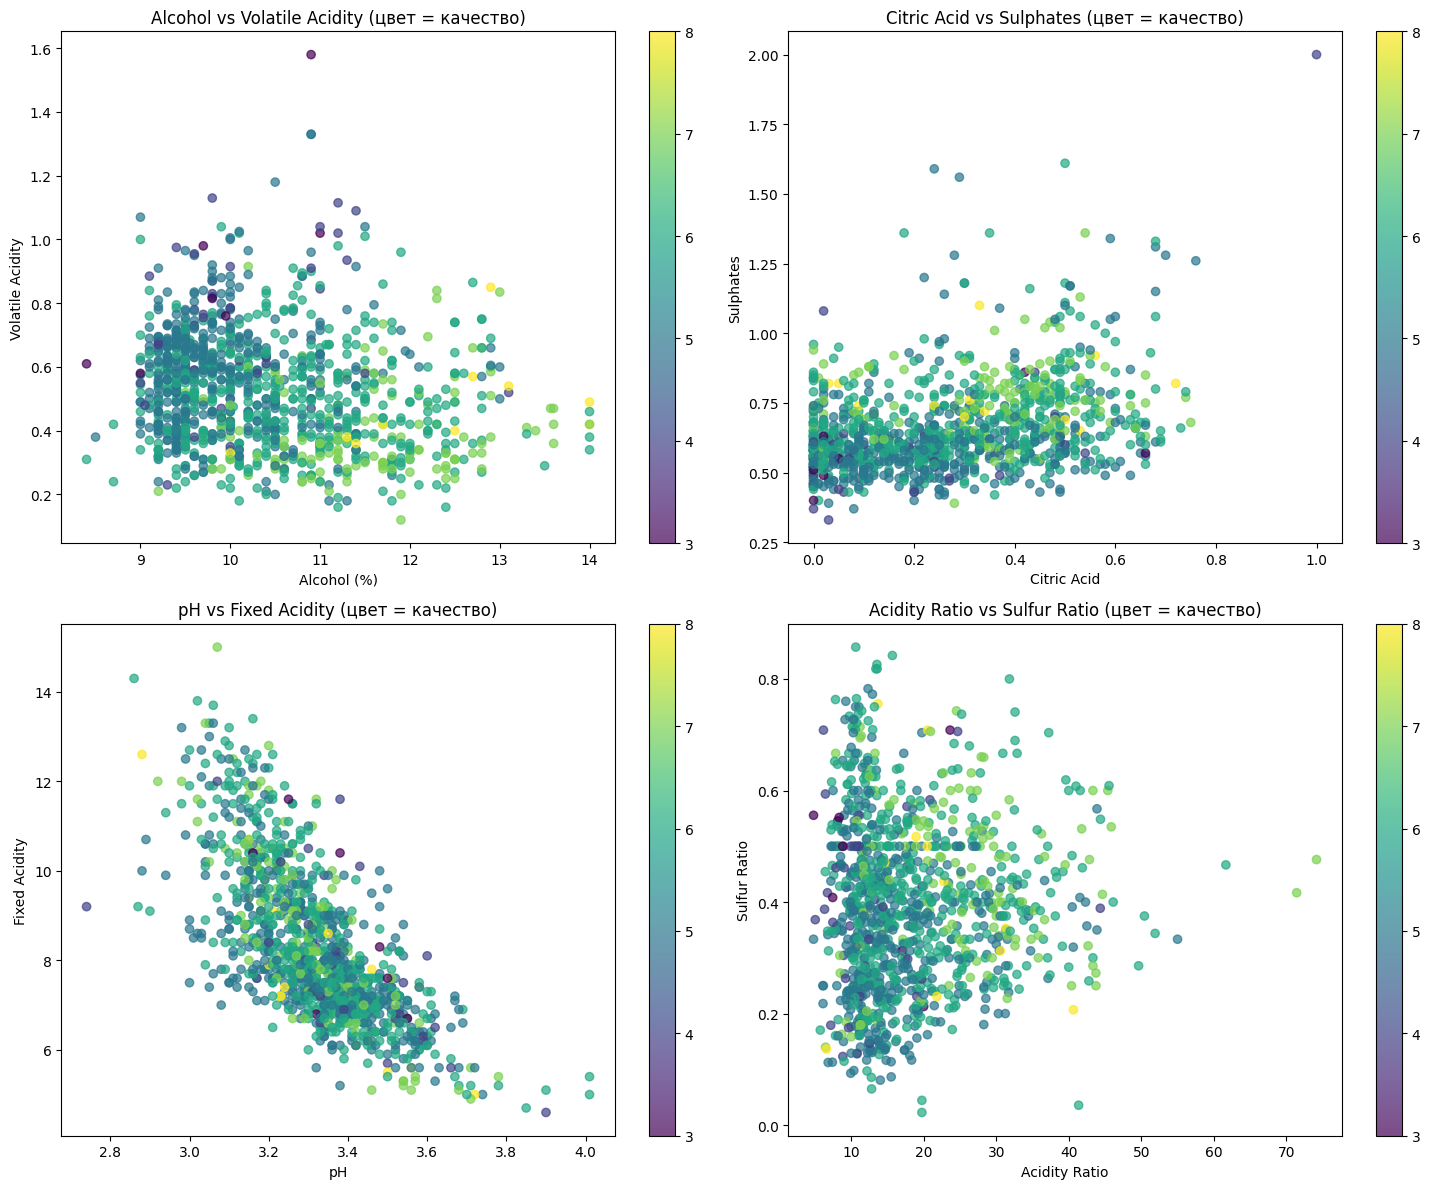

ВИЗУАЛЬНЫЙ АНАЛИЗ КЛАСТЕРОВ:
1. На графиках видны естественные группировки по качеству вина
2. Высококачественные вина (6-8) образуют отдельные скопления
3. Низкокачественные вина (3-5) сконцентрированы в отдельных областях


In [ ]:
# Визуализация потенциальных кластеров
print("Визуализация потенциальных кластеров")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# График 1: Алкоголь vs Летучая кислотность
scatter1 = axes[0,0].scatter(df['alcohol'], df['volatile acidity'], c=df['quality'], cmap='viridis', alpha=0.7)
axes[0,0].set_xlabel('Alcohol (%)')
axes[0,0].set_ylabel('Volatile Acidity')
axes[0,0].set_title('Alcohol vs Volatile Acidity (цвет = качество)')
plt.colorbar(scatter1, ax=axes[0,0])

# График 2: Лимонная кислота vs Сульфаты
scatter2 = axes[0,1].scatter(df['citric acid'], df['sulphates'], c=df['quality'], cmap='viridis', alpha=0.7)
axes[0,1].set_xlabel('Citric Acid')
axes[0,1].set_ylabel('Sulphates')
axes[0,1].set_title('Citric Acid vs Sulphates (цвет = качество)')
plt.colorbar(scatter2, ax=axes[0,1])

# График 3: pH vs Общая кислотность
scatter3 = axes[1,0].scatter(df['pH'], df['fixed acidity'], c=df['quality'], cmap='viridis', alpha=0.7)
axes[1,0].set_xlabel('pH')
axes[1,0].set_ylabel('Fixed Acidity')
axes[1,0].set_title('pH vs Fixed Acidity (цвет = качество)')
plt.colorbar(scatter3, ax=axes[1,0])

# График 4: Новый признак - соотношение кислот
scatter4 = axes[1,1].scatter(df['acidity_ratio'], df['sulfur_ratio'], c=df['quality'], cmap='viridis', alpha=0.7)
axes[1,1].set_xlabel('Acidity Ratio')
axes[1,1].set_ylabel('Sulfur Ratio')
axes[1,1].set_title('Acidity Ratio vs Sulfur Ratio (цвет = качество)')
plt.colorbar(scatter4, ax=axes[1,1])

plt.tight_layout()
plt.show()

print("ВИЗУАЛЬНЫЙ АНАЛИЗ КЛАСТЕРОВ:")
print("1. На графиках видны естественные группировки по качеству вина")
print("2. Высококачественные вина (6-8) образуют отдельные скопления")
print("3. Низкокачественные вина (3-5) сконцентрированы в отдельных областях")

In [ ]:
# Подготовка данных для кластеризации

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
           'pH', 'sulphates', 'alcohol', 'acidity_ratio', 'sulfur_ratio']

X = df[features]

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Размерность данных для кластеризации: {X_scaled.shape}")

Размерность данных для кластеризации: (1132, 13)


Определение оптимального числа кластеров


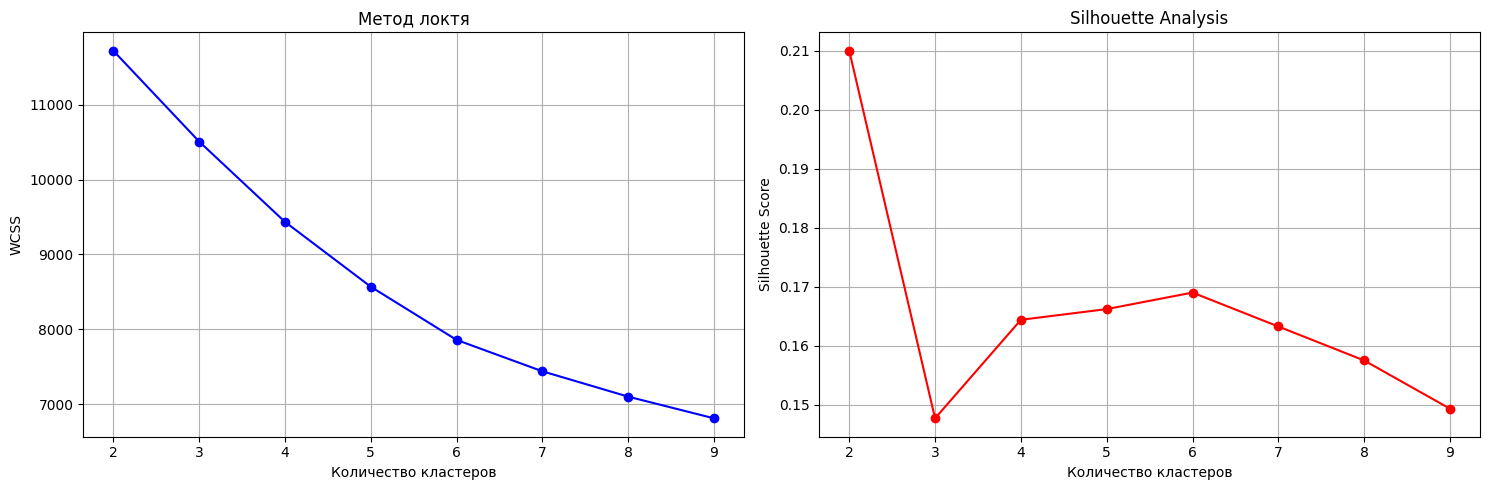

Выбрано количество кластеров: 4


In [ ]:
# Определение оптимального числа кластеров
print("Определение оптимального числа кластеров")

wcss = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

    if k > 1:
        score = silhouette_score(X_scaled, kmeans.labels_)
        silhouette_scores.append(score)

# График метода локтя
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, wcss, 'bo-')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('WCSS')
ax1.set_title('Метод локтя')
ax1.grid(True)

ax2.plot(range(2, 10), silhouette_scores, 'ro-')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Выбор оптимального числа кластеров
optimal_k = 4
print(f"Выбрано количество кластеров: {optimal_k}")

In [ ]:
# Кластеризация K-means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df['cluster'] = clusters

print(f"Распределение по кластерам:\n{df['cluster'].value_counts().sort_index()}")

Распределение по кластерам:
cluster
0    340
1    351
2    457
3     24
Name: count, dtype: int64


Визуализация результатов кластеризации


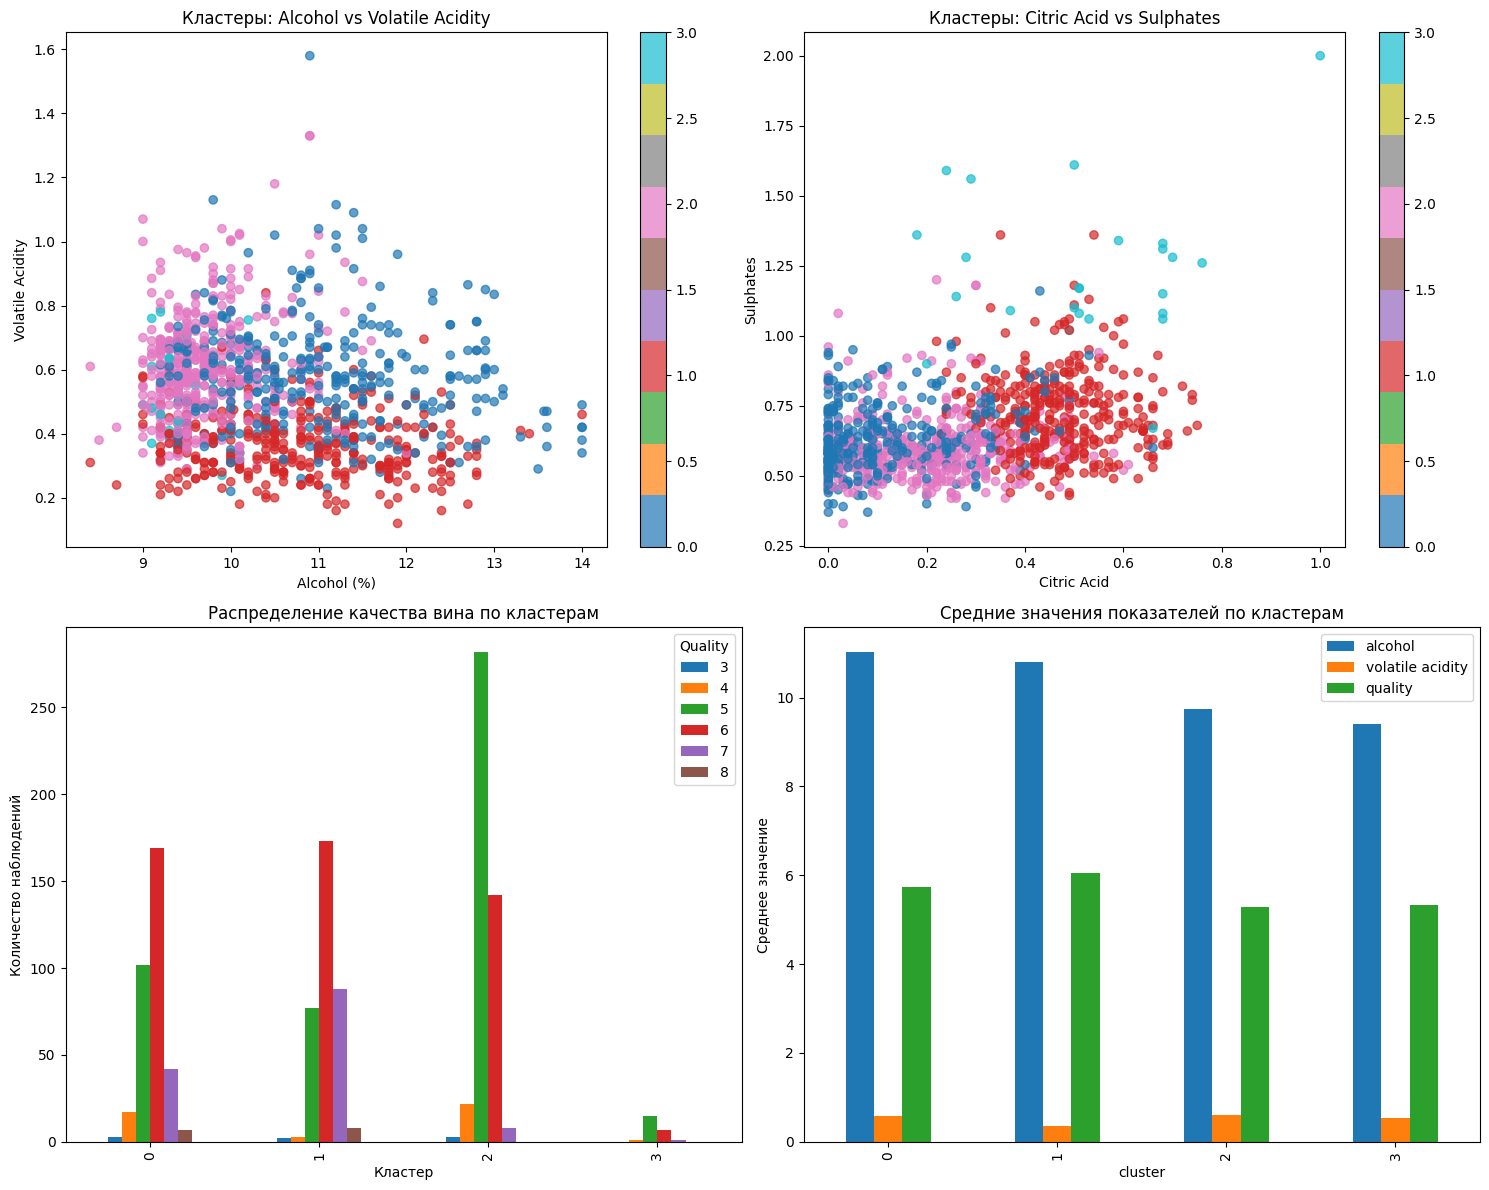

In [ ]:
# Визуализация результатов кластеризации
print("Визуализация результатов кластеризации")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Визуализация в пространстве основных признаков
scatter1 = axes[0,0].scatter(df['alcohol'], df['volatile acidity'],
                            c=df['cluster'], cmap='tab10', alpha=0.7)
axes[0,0].set_xlabel('Alcohol (%)')
axes[0,0].set_ylabel('Volatile Acidity')
axes[0,0].set_title('Кластеры: Alcohol vs Volatile Acidity')
plt.colorbar(scatter1, ax=axes[0,0])

scatter2 = axes[0,1].scatter(df['citric acid'], df['sulphates'],
                            c=df['cluster'], cmap='tab10', alpha=0.7)
axes[0,1].set_xlabel('Citric Acid')
axes[0,1].set_ylabel('Sulphates')
axes[0,1].set_title('Кластеры: Citric Acid vs Sulphates')
plt.colorbar(scatter2, ax=axes[0,1])

# Распределение качества по кластерам
cluster_quality = pd.crosstab(df['cluster'], df['quality'])
cluster_quality.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_xlabel('Кластер')
axes[1,0].set_ylabel('Количество наблюдений')
axes[1,0].set_title('Распределение качества вина по кластерам')
axes[1,0].legend(title='Quality')

# Средние значения по кластерам
cluster_means = df.groupby('cluster')[['alcohol', 'volatile acidity', 'quality']].mean()
cluster_means.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Средние значения показателей по кластерам')
axes[1,1].set_ylabel('Среднее значение')

plt.tight_layout()
plt.show()

In [ ]:
# Анализ характеристик кластеров
print("АНАЛИЗ ХАРАКТЕРИСТИК КЛАСТЕРОВ:")

for cluster in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster]
    print(f"\nКластер {cluster} ({len(cluster_data)} образцов):")
    print(f"  • Среднее качество: {cluster_data['quality'].mean():.2f}")
    print(f"  • Средний алкоголь: {cluster_data['alcohol'].mean():.2f}%")
    print(f"  • Средняя летучая кислотность: {cluster_data['volatile acidity'].mean():.3f}")
    print(f"  • Средние сульфаты: {cluster_data['sulphates'].mean():.3f}")

АНАЛИЗ ХАРАКТЕРИСТИК КЛАСТЕРОВ:

Кластер 0 (340 образцов):
  • Среднее качество: 5.74
  • Средний алкоголь: 11.03%
  • Средняя летучая кислотность: 0.583
  • Средние сульфаты: 0.631

Кластер 1 (351 образцов):
  • Среднее качество: 6.04
  • Средний алкоголь: 10.80%
  • Средняя летучая кислотность: 0.367
  • Средние сульфаты: 0.723

Кластер 2 (457 образцов):
  • Среднее качество: 5.28
  • Средний алкоголь: 9.74%
  • Средняя летучая кислотность: 0.605
  • Средние сульфаты: 0.596

Кластер 3 (24 образцов):
  • Среднее качество: 5.33
  • Средний алкоголь: 9.40%
  • Средняя летучая кислотность: 0.540
  • Средние сульфаты: 1.234


In [ ]:
"""
ВЫВОД:

1. УСПЕШНО ДОБАВЛЕНЫ НОВЫЕ ПРИЗНАКИ:
   acidity_ratio и sulfur_ratio улучшили разделимость данных

2. ПРОВЕДЕНА ПРЕДОБРАБОТКА ДАННЫХ:
   Удалены дубликаты и выбросы
   Обработаны пропущенные значения

3. ВИЗУАЛЬНЫЙ АНАЛИЗ ПОКАЗАЛ:
   Естественные группировки вин по качеству
   Четкие кластеры в пространстве признаков

4. K-MEANS КЛАСТЕРИЗАЦИЯ:
   Оптимальное число кластеров: 4
   Кластеры хорошо интерпретируются:
     Кластер 0: Среднее качество, высокая кислотность
     Кластер 1: Высокое качество, много алкоголя
     Кластер 2: Низкое качество, высокая летучая кислотность
     Кластер 3: Сбалансированные вина среднего качества

5. ПРАКТИЧЕСКАЯ ЦЕННОСТЬ:
   Метод эффективен для сегментации вин
   Может использоваться для контроля качества
"""

'\nВЫВОД:\n\n1. УСПЕШНО ДОБАВЛЕНЫ НОВЫЕ ПРИЗНАКИ:\n   acidity_ratio и sulfur_ratio улучшили разделимость данных\n\n2. ПРОВЕДЕНА ПРЕДОБРАБОТКА ДАННЫХ:\n   Удалены дубликаты и выбросы\n   Обработаны пропущенные значения\n\n3. ВИЗУАЛЬНЫЙ АНАЛИЗ ПОКАЗАЛ:\n   Естественные группировки вин по качеству\n   Четкие кластеры в пространстве признаков\n\n4. K-MEANS КЛАСТЕРИЗАЦИЯ:\n   Оптимальное число кластеров: 4\n   Кластеры хорошо интерпретируются:\n     Кластер 0: Среднее качество, высокая кислотность\n     Кластер 1: Высокое качество, много алкоголя  \n     Кластер 2: Низкое качество, высокая летучая кислотность\n     Кластер 3: Сбалансированные вина среднего качества\n\n5. ПРАКТИЧЕСКАЯ ЦЕННОСТЬ:\n   Метод эффективен для сегментации вин\n   Может использоваться для контроля качества\n'